## Setup - import libraries

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima_model import ARIMA


import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px
import numpy as np 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Utility functions

The block below is used to define the function to identify the stock return prediction trend accuracy 

In [3]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()
    

##  Data loading 


The block below is used to get the stock data and choose the desired features and rows. The code will also change the dataframe index to datetime for future analysis.

In [4]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock.index = pd.to_datetime(apple_stock.index)

[*********************100%%**********************]  1 of 1 completed


# Add the return columns (1-day, 5-day, 1-month)

The code below is used to add the potential targets: 1-day. five-day and 1-month stock returns. The returns are calculated compared with the historical data. 

In [7]:
apple_stock['1-Day Return'] = apple_stock['Adj Close'].pct_change(1) * 100
apple_stock['5-Day Return'] = apple_stock['Adj Close'].pct_change(5) * 100
apple_stock['1-Month Return'] = apple_stock['Adj Close'].pct_change(21) * 100
apple_stock = apple_stock.dropna()

The code below is showing the plotting of the different returns by making subplots.

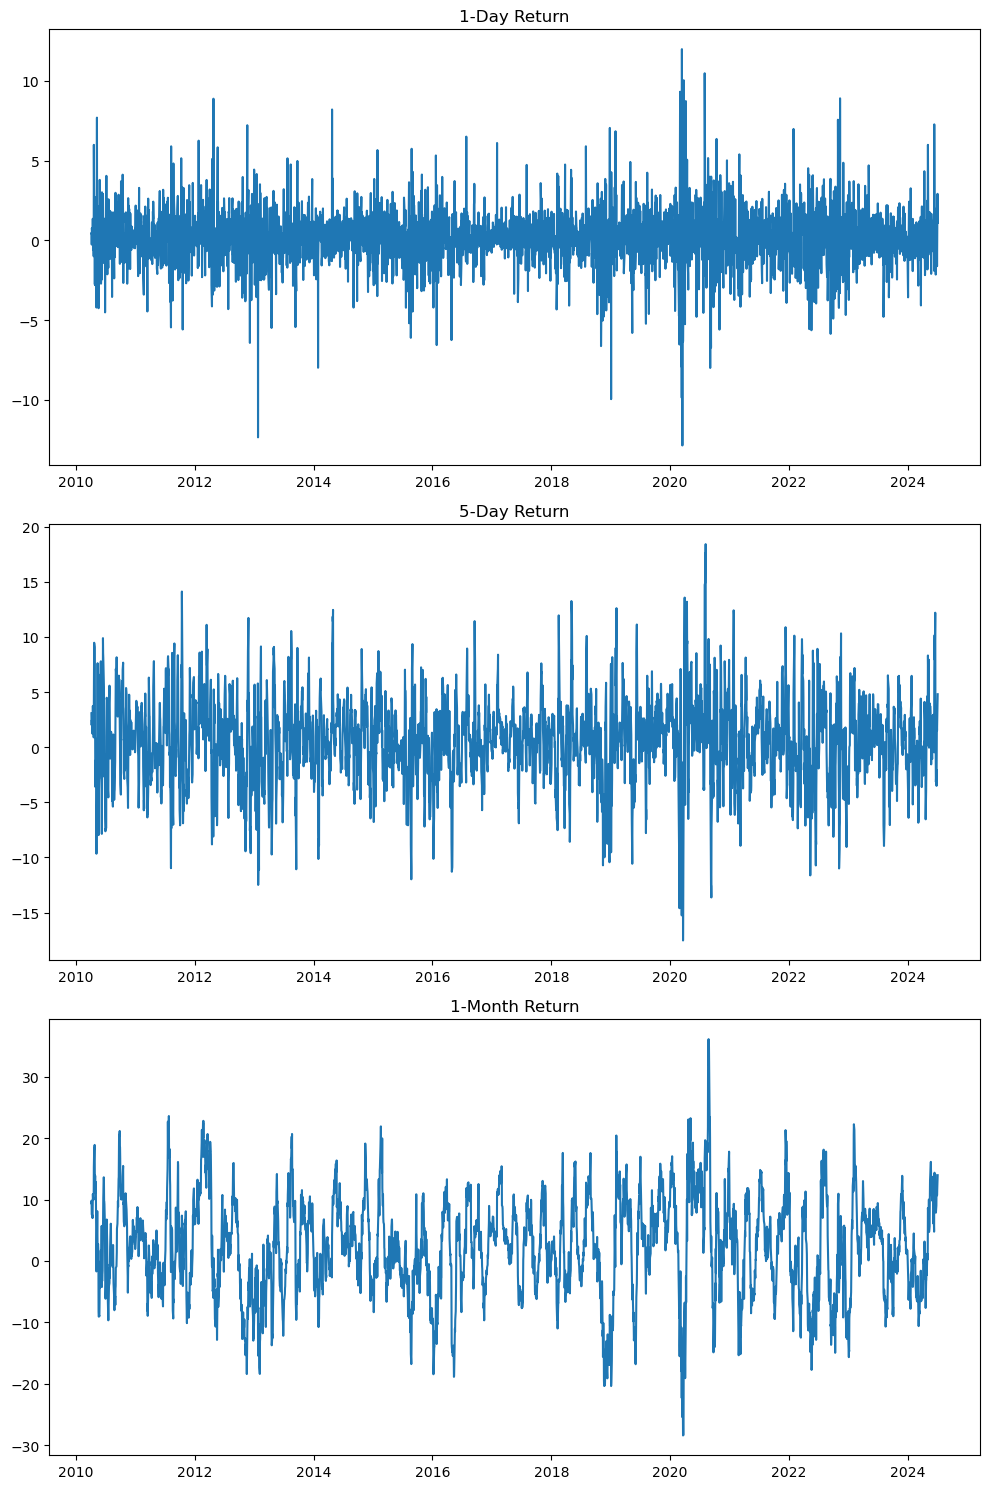

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting 1-Day Return
axs[0].plot(apple_stock.index, apple_stock['1-Day Return'])
axs[0].set_title('1-Day Return')

# Plotting 5-Day Return
axs[1].plot(apple_stock.index, apple_stock['5-Day Return'])
axs[1].set_title('5-Day Return')

# Plotting 1-Month Return
axs[2].plot(apple_stock.index, apple_stock['1-Month Return'])
axs[2].set_title('1-Month Return')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##  Train-test split

In [15]:
train = apple_stock[apple_stock.index <= '2024-02-01']
test = apple_stock[apple_stock.index > '2024-02-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (3481, 5)
Test set size: (104, 5)


## Check the qdp of the time series analysis

The code below is used to determine the (p,d,q) parameters that will be used in the further time series model. The sequence is 1-day, 5-day, 1-month.

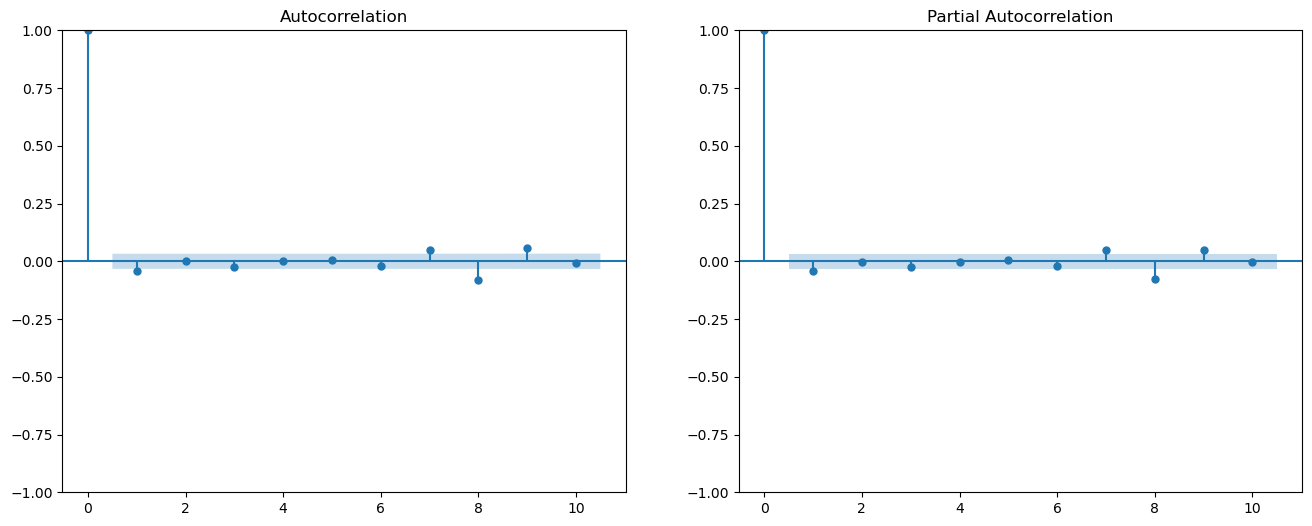

In [17]:
# For 1-day return 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(apple_stock['1-Day Return'], lags=10, ax=axes[0])
plot_pacf(apple_stock['1-Day Return'], lags=10, ax=axes[1])
plt.show()

We can see there seems to be very weak correlation between the current return and the historical returns in regards of autoregression term(p) which is shown in pacf and moving average term(q) in terms of acf plot. 

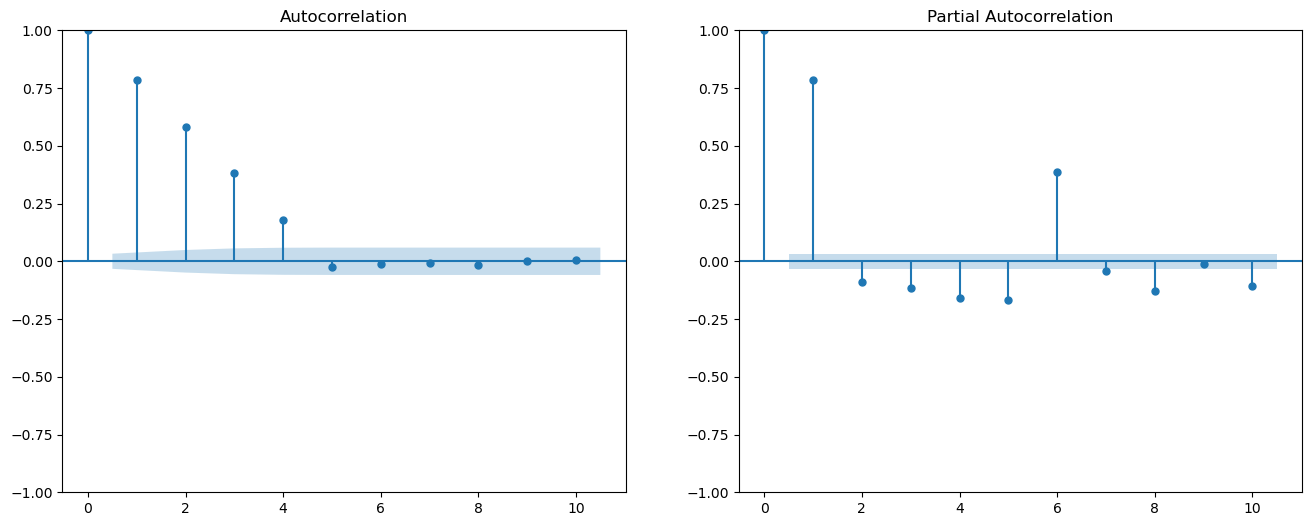

In [18]:
# 5days 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(apple_stock['5-Day Return'], lags=10, ax=axes[0])
plot_pacf(apple_stock['5-Day Return'], lags=10, ax=axes[1])
plt.show()

Acording to the pacf, the potential useful combination of parameters for 5-day prediction is (7, 0, 0). If the ACF values show a gradual decrease, it often indicates an autoregressive (AR) process rather than a moving average process. This process suggests that we should be looking at the Partial Autocorrelation Function (PACF) for a better understanding.

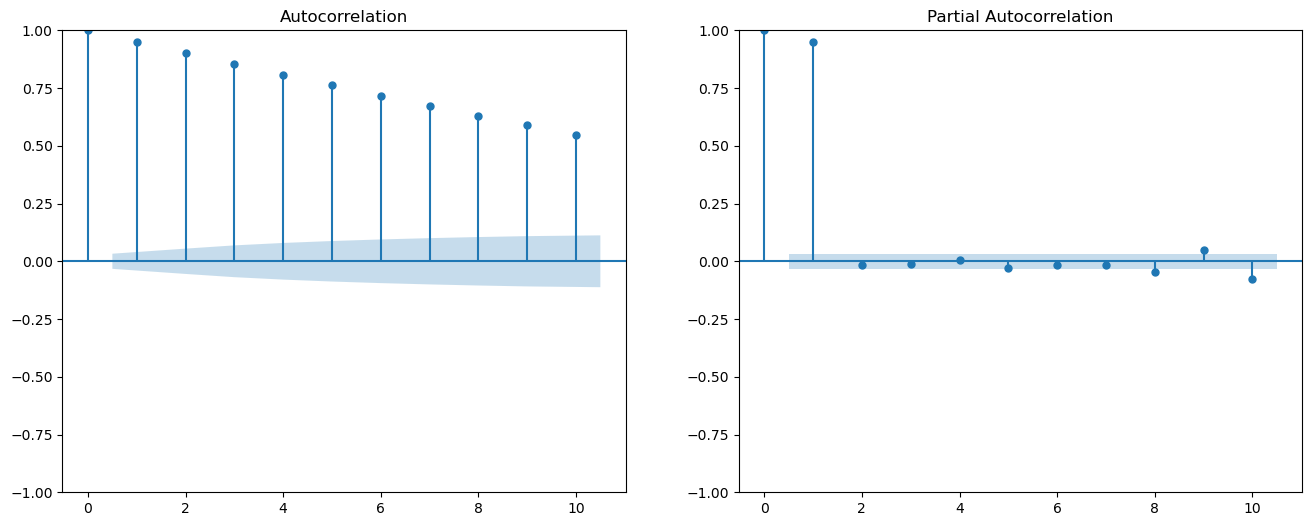

In [20]:
# 1-month
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(apple_stock['1-Month Return'], lags=10, ax=axes[0])
plot_pacf(apple_stock['1-Month Return'], lags=10, ax=axes[1])
plt.show()

Again here, based on the same reason above, we conclude that (2, 0, 0) is the potential parameter for the 1-month return validation.

##  Arima model for 1-day return prediction

### ARIMA model fitting trial 

In [ ]:
model1 = ARIMA(train['1-Day Return'], order=(1, 0, 0)) # Although we believe there is no strong correction between current day return and historical values, we set p = 1 as a test
model1_fit = model1.fit()
print(model1_fit.summary())

As we can see the coefficient ar.L1 is quite small which is literally saying that the next day return prediction is 10% of today's value. We can intuitively imagine that this is not realistic. The potential reason for this is because there is a stoicastic process involved in predicting the next day return of a stock. A more realistic method to solve is to including the idea of BS equation. The more detailed  discussion will be covered in later notebooks.

###  Set 1: Prediction based on a model fitted on top of all the past data. 

The code below is to use the rolling process to predict the stock price 1-day return. Although we know that it would be inaccurate in predicting the return value. It would still be interesting in estimating whether the model can predict the trend (positive or negative correctly).

In [ ]:
# !pip install tqdm
from tqdm import tqdm

In [174]:
# Assuming `history` is a list of historical returns and `test` is a DataFrame with the '1-Day Return' column
history = train['1-Day Return'].tolist() # Convert the 1-day return trainning data as a list

predictions = []
threshold_5days = []

for t in tqdm(range(len(test)), desc="Processing"):
    # Fit ARIMA model
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    # Calculate 5-day moving average and standard deviation
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    else:
        threshold_5days.append(None)  # Not enough data to calculate moving average and std

    # Get the next observation from the test set
    obs = test['1-Day Return'].iloc[t]
    history.append(obs)

Processing: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]


Code below will help us to visualize the rolling fitting process and we can find that the 1-day return is very difficult to be predicted only with the ARIMA model.

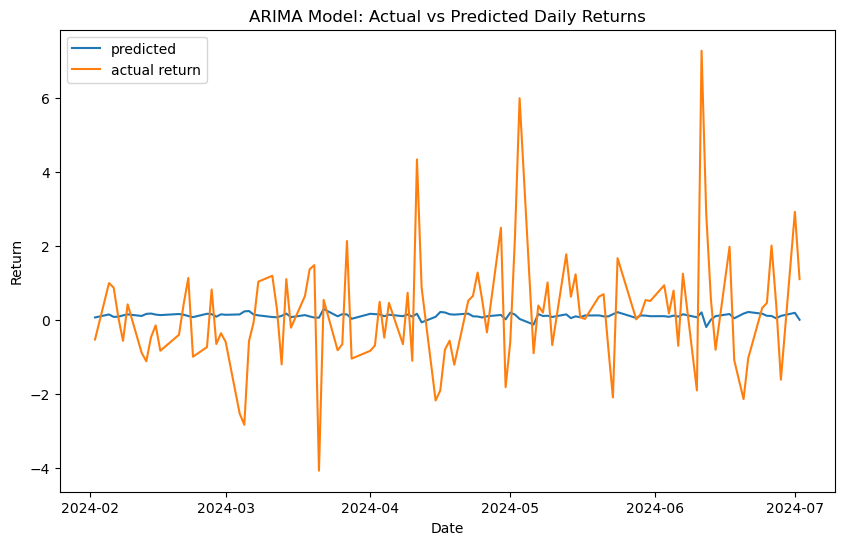

In [175]:
df1 = pd.DataFrame(data=predictions, index=test.index, columns=['1-Day predicted today'])
df1['threshold'] = threshold_5days


plt.figure(figsize = (10,6))
plt.plot(df1['1-Day predicted today'], label = 'predicted')
plt.plot(test['1-Day Return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted Daily Returns')
plt.legend()
plt.show()

We introduce the idea of classification model metrics here to see the performance of the ARIMA model in tracking the trend of the next-day return.

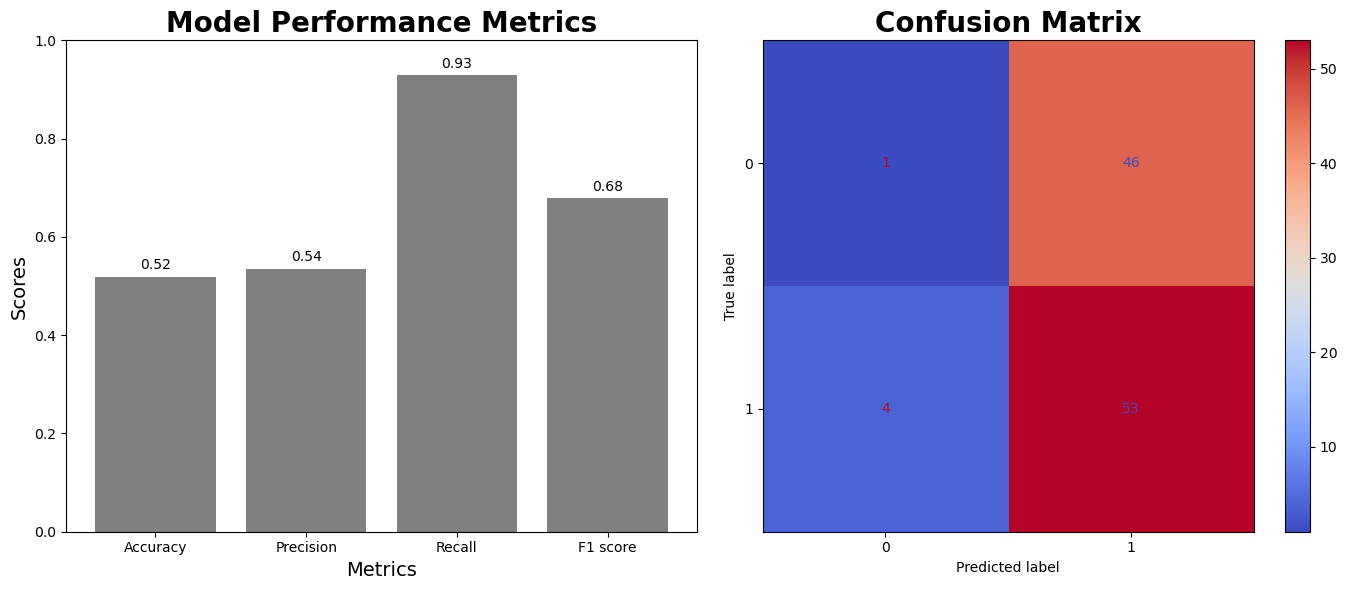

In [176]:
df1['1_Day predicted binary'] = np.where(df1['1-Day predicted today'] >0, 1,0)   # relaxed condition
df1['1-Day real return binary'] = np.where(test['1-Day Return']>0, 1, 0)
plot_model_performance(df1['1_Day predicted binary'], df1['1-Day real return binary'])

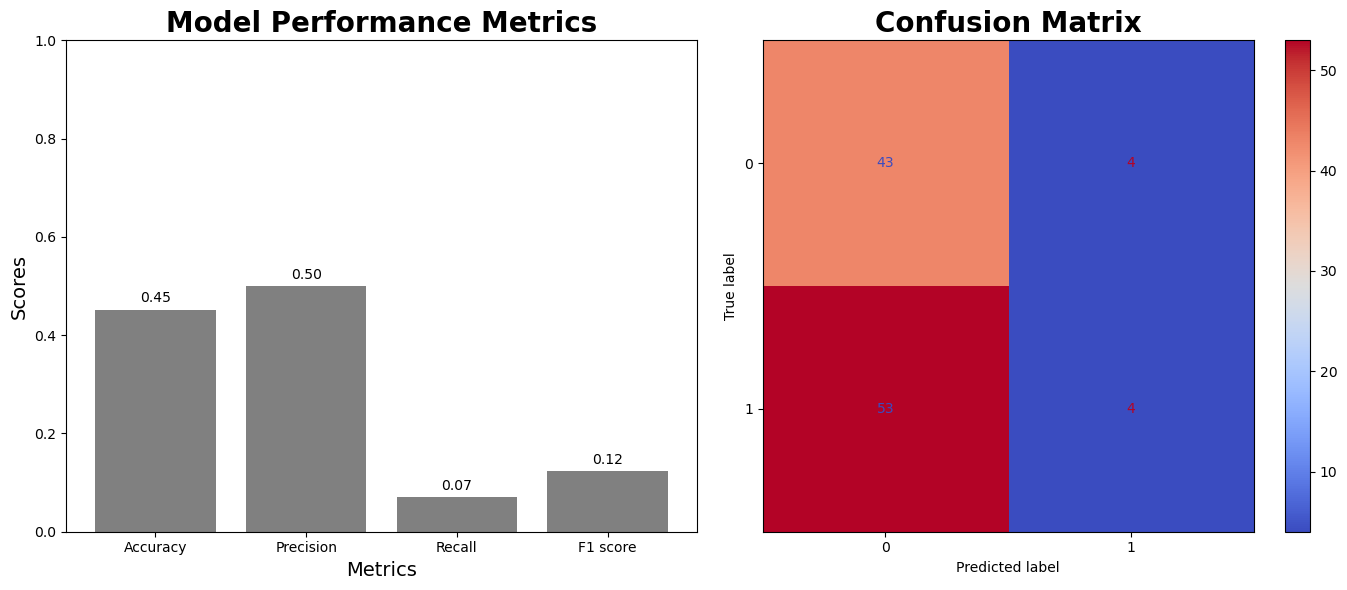

In [177]:
df1['1_Day predicted binary'] = np.where((df1['1-Day predicted today'] >0) & (df1['1-Day predicted today']> df1['threshold']), 1,0)   # tight condition
plot_model_performance(df1['1_Day predicted binary'], df1['1-Day real return binary'])

As we can see, if we fully trust the predicted result and not add any bias in determining the positive trend, the prediction accuracy is still slightly lower than the dummy model: ~55% of precision. After playing with the condition, we will find the precision is even lower(when predicted value is higher than 1 std above the past five day moving average, we identify the trend as positive).

### Set 2: Prediction based on the rolling window fitting.

In [178]:
# Assuming `history` is a list of historical returns and `test` is a DataFrame with the '1-Day Return' column
history = train['1-Day Return'].tolist() # Convert the 1-day return trainning data as a list

predictions = []
threshold_5days = []

for t in tqdm(range(len(test)), desc="Processing"):
    # Fit ARIMA model
    model = ARIMA(history[-50:], order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    # Calculate 5-day moving average and standard deviation
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    else:
        threshold_5days.append(None)  # Not enough data to calculate moving average and std

    # Get the next observation from the test set
    obs = test['1-Day Return'].iloc[t]
    history.append(obs)

Processing: 100%|██████████| 104/104 [00:01<00:00, 67.29it/s]


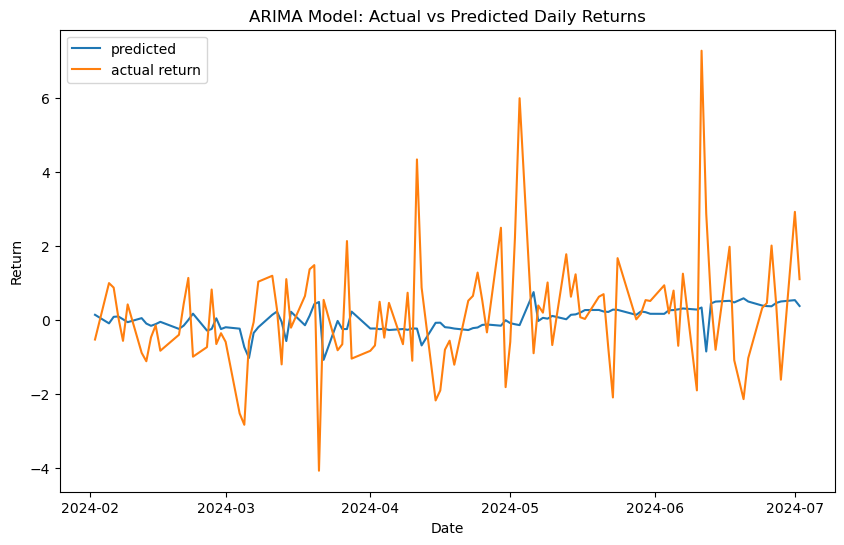

In [179]:
df1 = pd.DataFrame(data=predictions, index=test.index, columns=['1-Day predicted today'])
df1['threshold'] = threshold_5days

plt.figure(figsize = (10,6))
plt.plot(df1['1-Day predicted today'], label = 'predicted')
plt.plot(test['1-Day Return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted Daily Returns')
plt.legend()
plt.show()

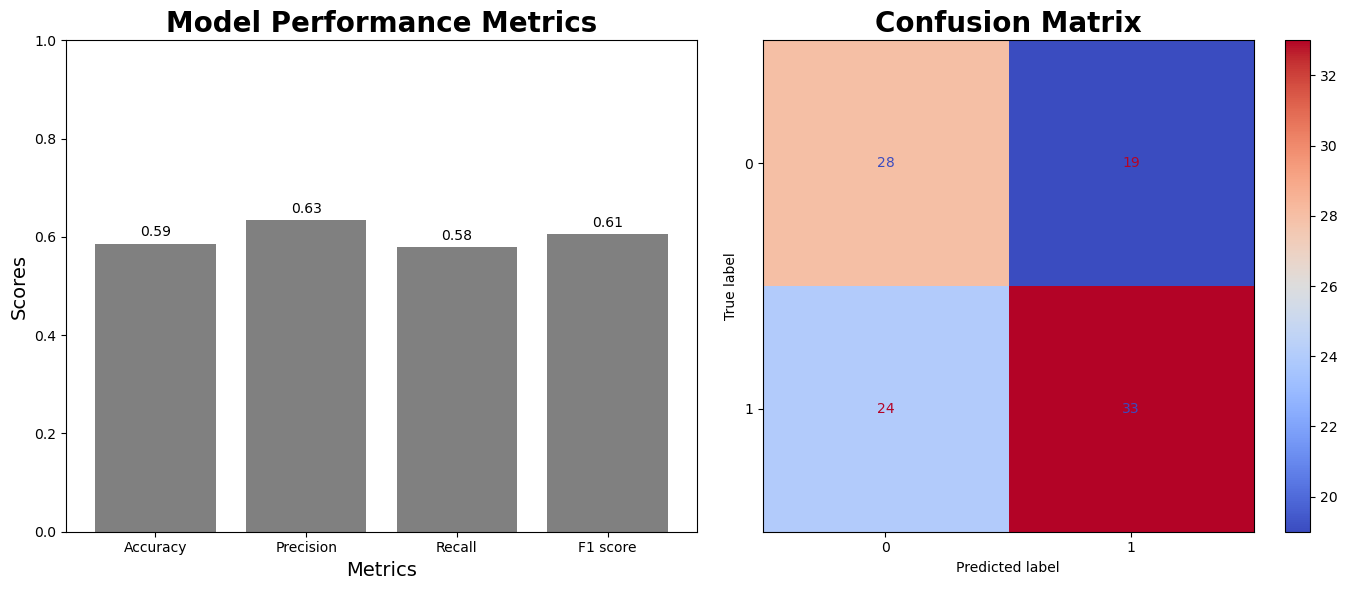

In [180]:
df1['1_Day predicted binary'] = np.where(df1['1-Day predicted today'] >0, 1,0)   # relaxed condition
df1['1-Day real return binary'] = np.where(test['1-Day Return']>0, 1, 0)
plot_model_performance(df1['1_Day predicted binary'], df1['1-Day real return binary'])

As we can see, the rolling window trainning method is doing much better job in terms of the 1-Day return prediction

c:\Users\12436\.conda\envs\Capstones\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


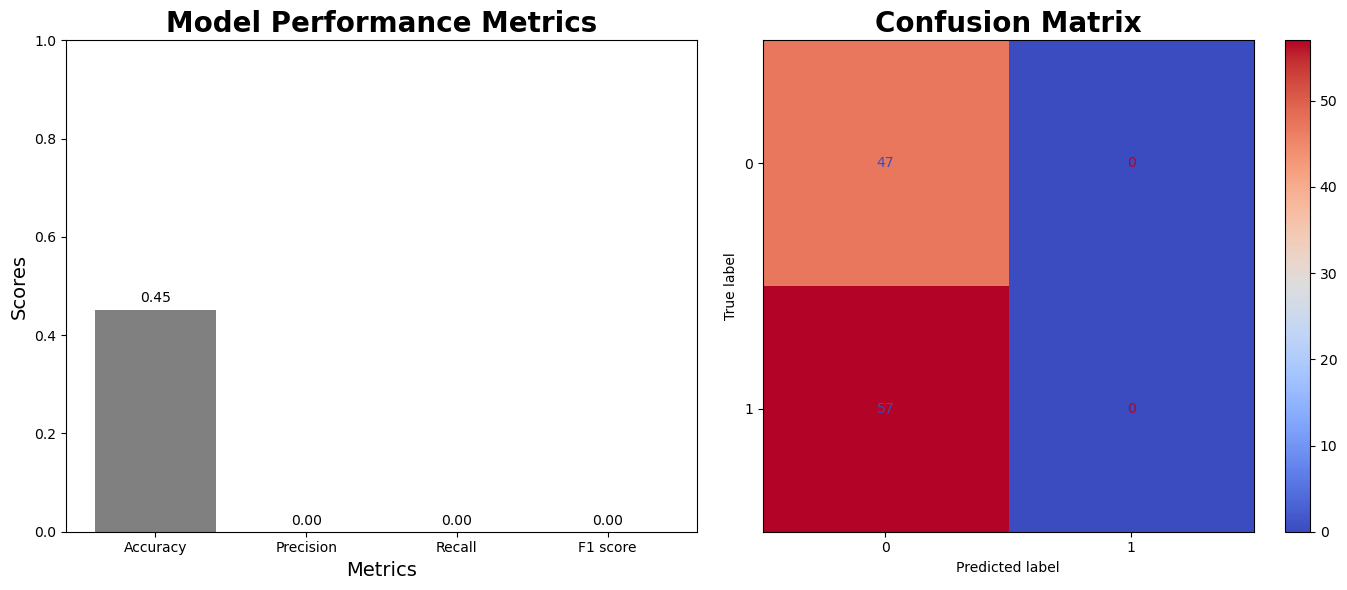

In [181]:
df1['1_Day predicted binary'] = np.where((df1['1-Day predicted today'] >0) & (df1['1-Day predicted today']> df1['threshold']), 1,0)   # tight condition
plot_model_performance(df1['1_Day predicted binary'], df1['1-Day real return binary'])

As we can see that the strict condition is playing very bad here in terms of the precision and also other metrics. 

# 5-day return prediction

In [ ]:
# 5-day return 
model5 = ARIMA(train['5-Day Return'], order=(7, 0, 0)) # maybe 7
model5_fit = model5.fit()
print(model5_fit.summary())

## Set 1: Use all existed data to train the model and make the prediction:

In [182]:
# Convert '5-Day Return' to list
history = train['5-Day Return'].tolist()
predictions = []
moving_avg_5days = []
moving_std_5days = []
threshold_5days = []


for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error
    # Fit the ARIMA model
    model = ARIMA(history, order=(7, 0, 0))
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    output = model_fit.forecast(steps=5)
    yhat = output[-1]  # Take the 5th day forecast from the current point
    predictions.append(yhat)
    
    # Calculate moving average and standard deviation for the last 5 days
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    
    # Get the actual value from the test set
    obs = test['5-Day Return'].iloc[t]
    history.append(obs)
    

Processing: 100%|██████████| 104/104 [01:38<00:00,  1.05it/s]


In [183]:
df5 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df5['predicted return difference compared with today_corrected'] = df5['predicted return difference compared with today'].shift(4)
df5['real return'] =  test['5-Day Return']
df5['threshold'] = threshold_5days
df5['threshold'] = df5['threshold'].shift(4)
df5.dropna(inplace=True, axis=0)

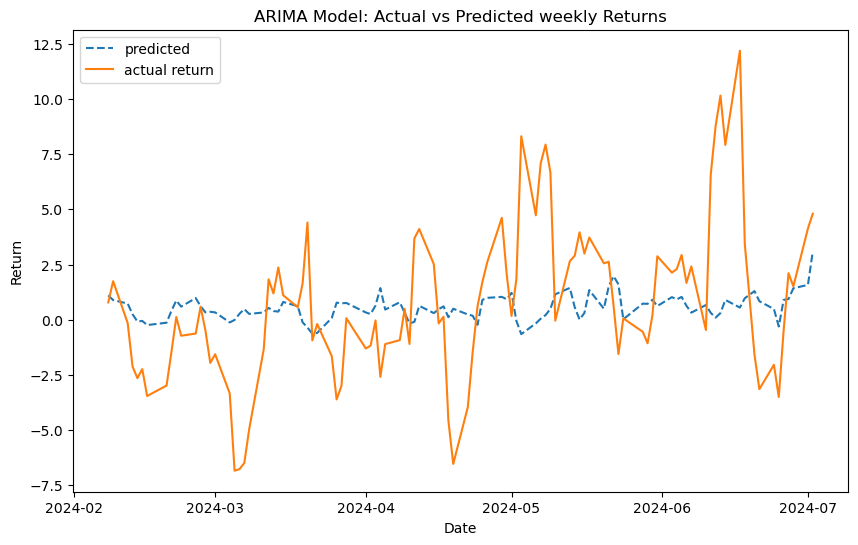

In [184]:
plt.figure(figsize = (10,6))

plt.plot(df5['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df5['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

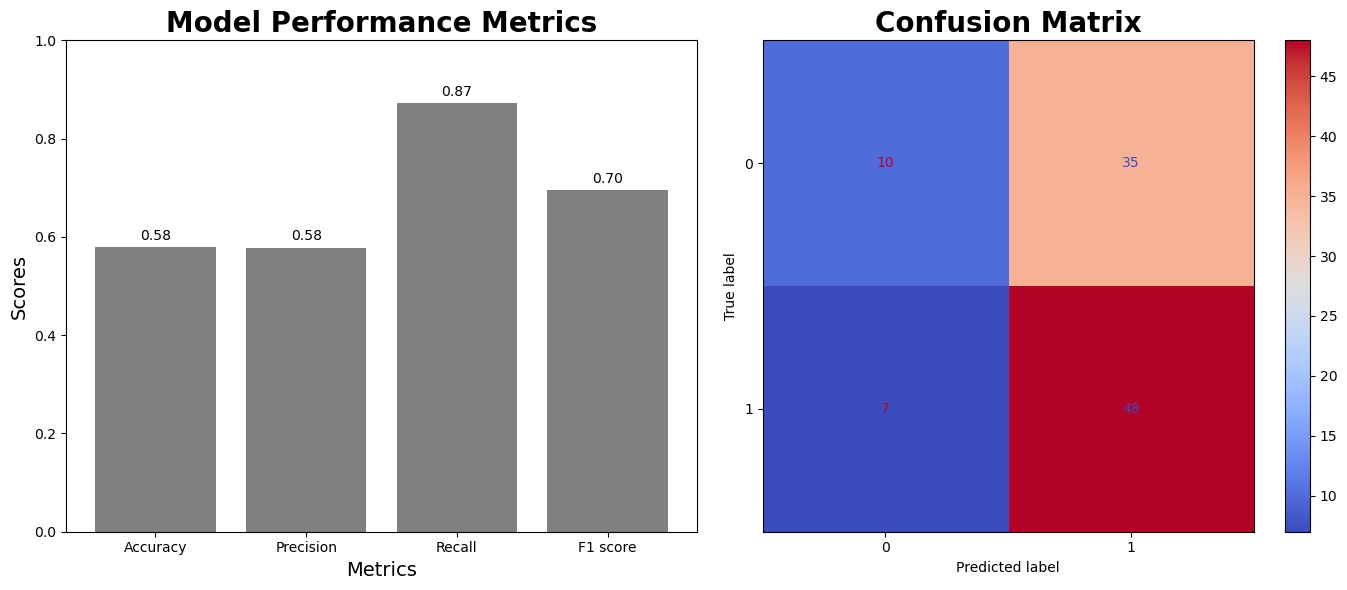

In [187]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

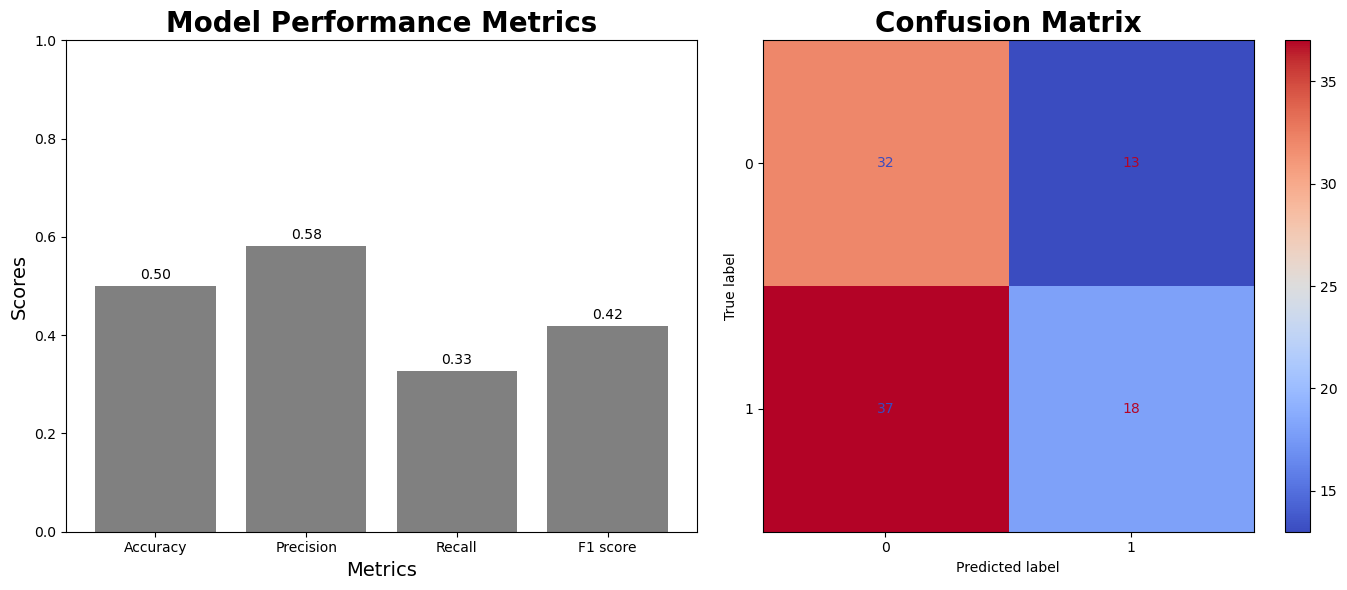

In [189]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0) & (df5['predicted return difference compared with today_corrected']>df5['threshold']), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

### Set 2: Use 1 year back data as the trainning set and try to make the validation 

In [191]:
# Convert '5-Day Return' to list
history = train['5-Day Return'].tolist()
predictions = []
threshold_5days = []

for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error
    # Fit the ARIMA model
    model = ARIMA(history[-300:], order=(7, 0, 0))
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    output = model_fit.forecast(steps=5)
    yhat = output[-1]  # Take the 5th day forecast from the current point
    predictions.append(yhat)
    
    # Calculate moving average and standard deviation for the last 5 days
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    
    # Get the actual value from the test set
    obs = test['5-Day Return'].iloc[t]
    history.append(obs)

Processing: 100%|██████████| 104/104 [00:25<00:00,  4.08it/s]


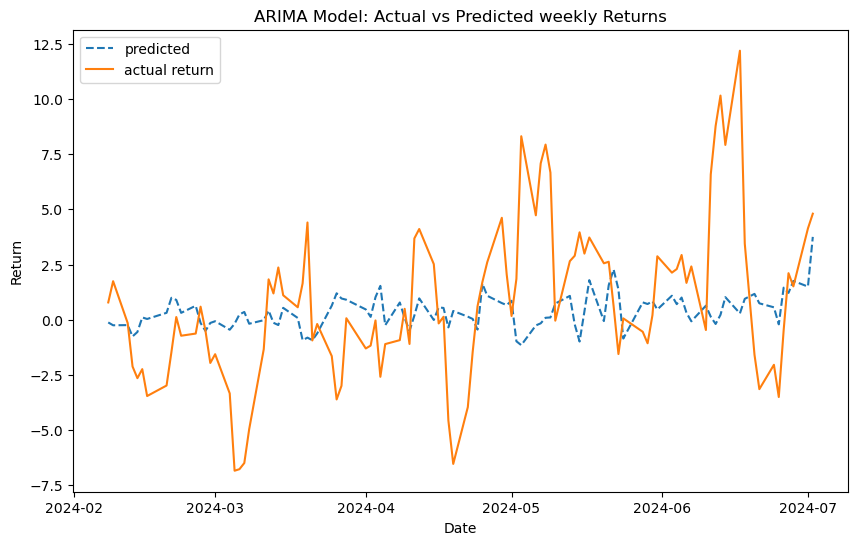

In [192]:
df5 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df5['predicted return difference compared with today_corrected'] = df5['predicted return difference compared with today'].shift(4)
df5['real return'] =  test['5-Day Return']
df5['threshold'] = threshold_5days
df5['threshold'] = df5['threshold'].shift(4)
df5.dropna(inplace=True, axis=0)

plt.figure(figsize = (10,6))
plt.plot(df5['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df5['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

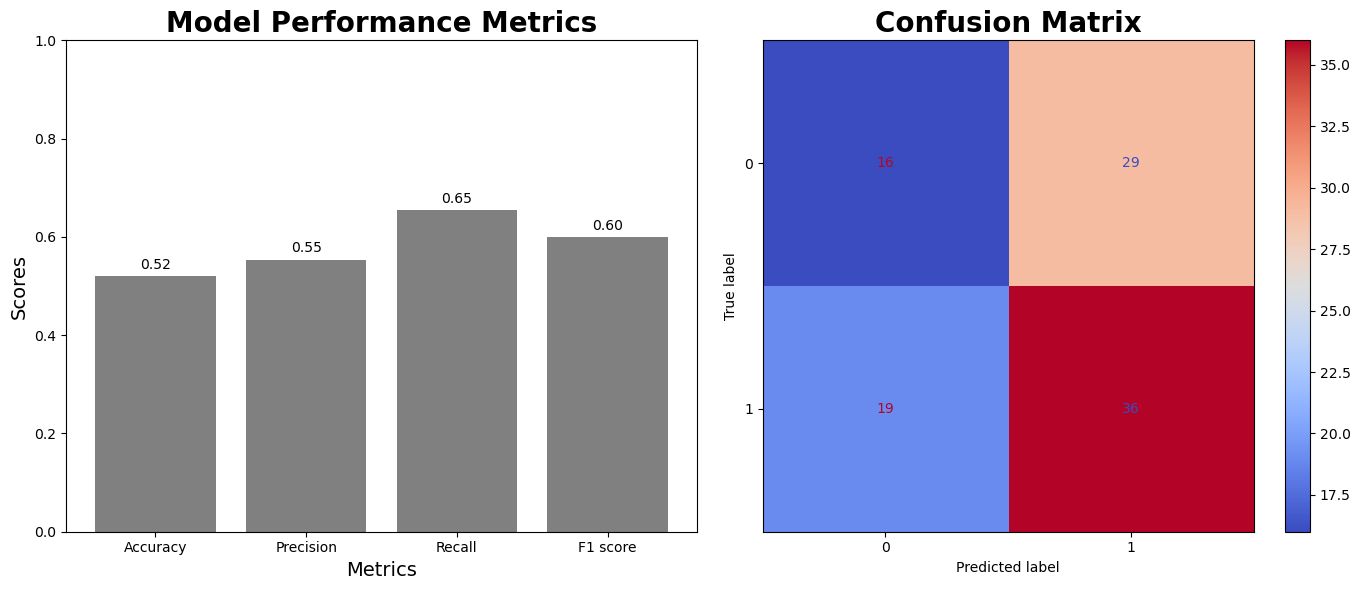

In [193]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

If we use the updated threshold, we will be able to see a huge increase of precision. We should bear in mind with this idea. 

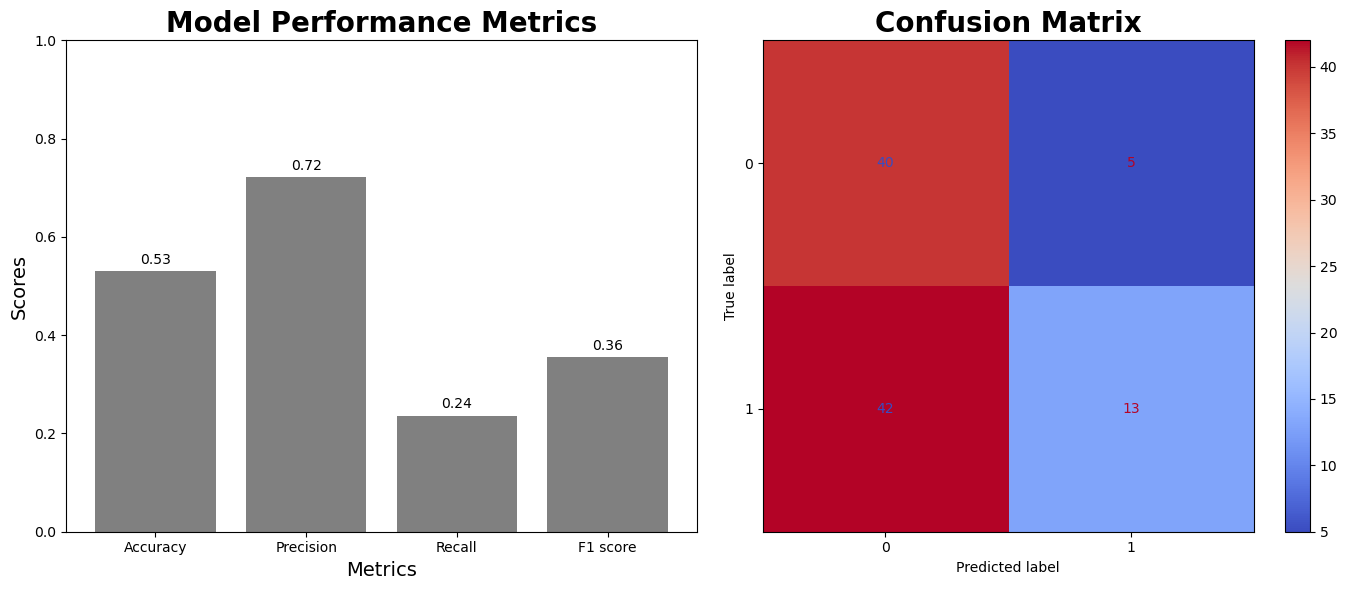

In [194]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0) & (df5['predicted return difference compared with today_corrected']>df5['threshold']), 1, 0)
# df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

## 1-Month return prediction 

In [ ]:
# 1 month return 
model21 = ARIMA(train['1-Month Return'], order=(1, 0, 0))
model21_fit = model21.fit()
print(model21_fit.summary())

### Set 1: use all the historical data to train the model 

In [127]:
# Convert '5-Day Return' to list
history = train['1-Month Return'].tolist()
predictions = []
threshold_5days = []


for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error
    # Fit the ARIMA model
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    output = model_fit.forecast(steps=21)
    yhat = output[-1]  # Take the 5th day forecast from the current point
    predictions.append(yhat)
    
    # Calculate moving average and standard deviation for the last 5 days
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    
    # Get the actual value from the test set
    obs = test['5-Day Return'].iloc[t]
    history.append(obs)
    

Processing: 100%|██████████| 104/104 [00:16<00:00,  6.28it/s]


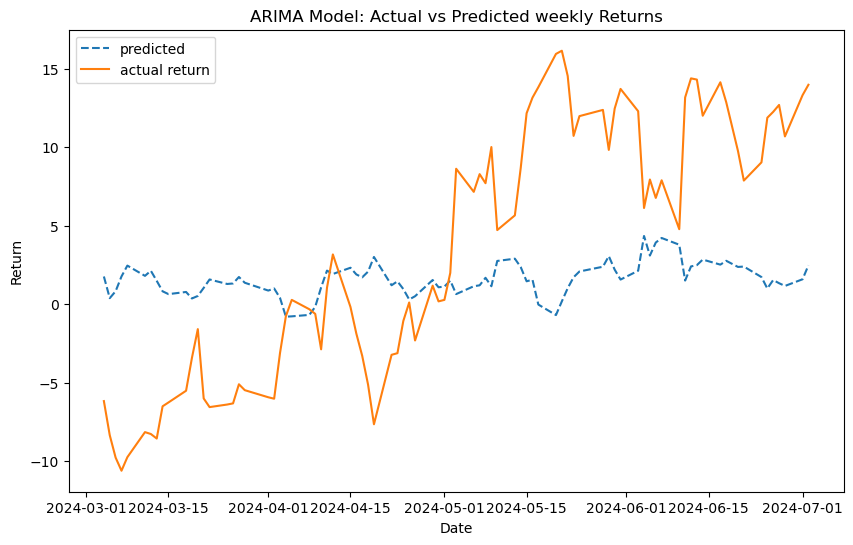

In [128]:
df21 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df21['predicted return difference compared with today_corrected'] = df21['predicted return difference compared with today'].shift(20)
df21['real return'] =  test['1-Month Return']
df21['threshold'] = threshold_5days
df21['threshold'] = df21['threshold'].shift(20)
df21.dropna(inplace=True, axis=0)

plt.figure(figsize = (10,6))
plt.plot(df21['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df21['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

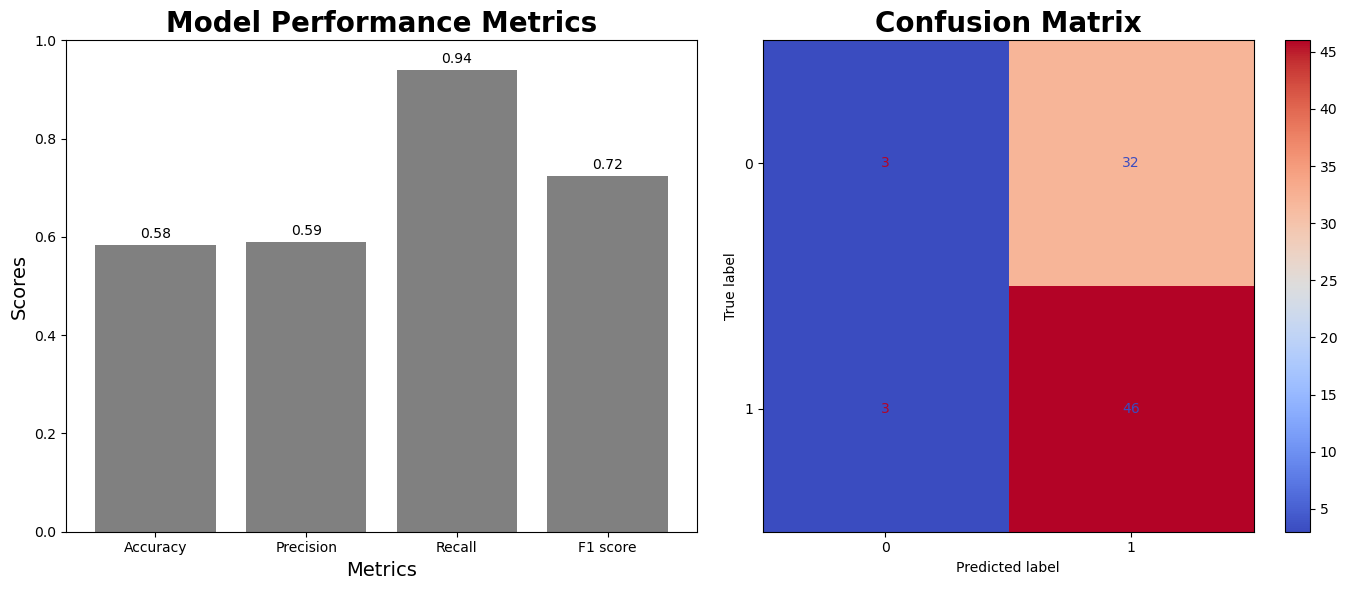

In [129]:
df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0), 1, 0)
df21['actual binary'] = np.where(df21['real return']>0, 1, 0)
plot_model_performance(df21['predicted binary'], df21['actual binary'])

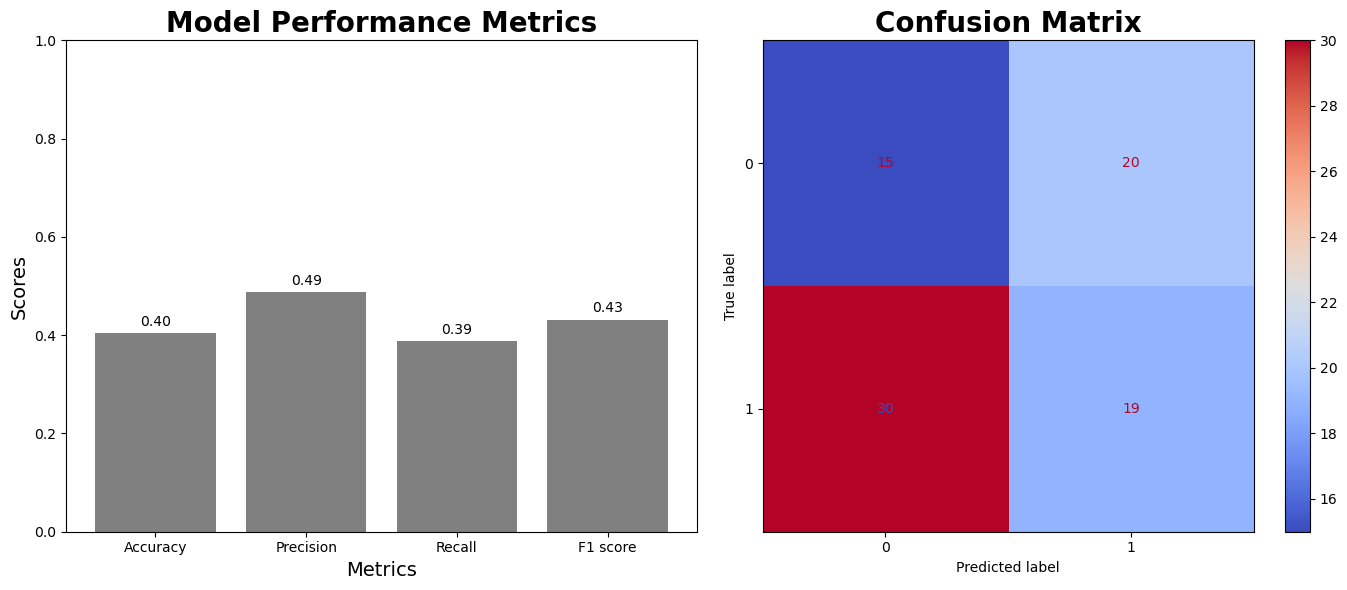

In [130]:
df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0) & (df21['predicted return difference compared with today_corrected']>df21['threshold']), 1, 0)
# df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0), 1, 0)
df21['actual binary'] = np.where(df21['real return']>0, 1, 0)
plot_model_performance(df21['predicted binary'], df21['actual binary'])

### Set 2: use past 300 days data to train the model 

In [159]:
# Convert '5-Day Return' to list
history = train['1-Month Return'].tolist()
predictions = []
threshold_5days = []


for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error
    # Fit the ARIMA model
    model = ARIMA(history[-500:], order=(1, 0, 0))
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    output = model_fit.forecast(steps=21)
    yhat = output[-1]  # Take the 5th day forecast from the current point
    predictions.append(yhat)
    
    # Calculate moving average and standard deviation for the last 5 days
    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)
    
    # Get the actual value from the test set
    obs = test['5-Day Return'].iloc[t]
    history.append(obs)
    

Processing: 100%|██████████| 104/104 [00:06<00:00, 15.53it/s]


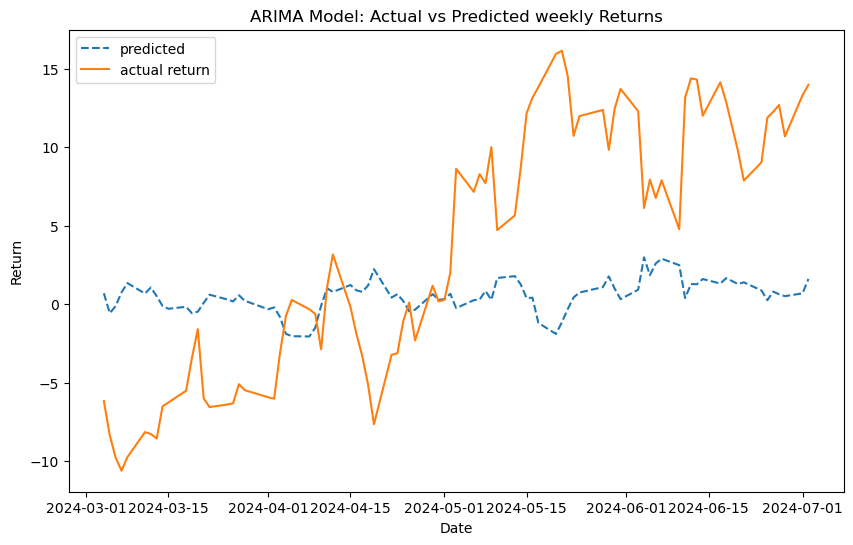

In [160]:
df21 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df21['predicted return difference compared with today_corrected'] = df21['predicted return difference compared with today'].shift(20)
df21['real return'] =  test['1-Month Return']
df21['threshold'] = threshold_5days
df21['threshold'] = df21['threshold'].shift(20)
df21.dropna(inplace=True, axis=0)

plt.figure(figsize = (10,6))
plt.plot(df21['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df21['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

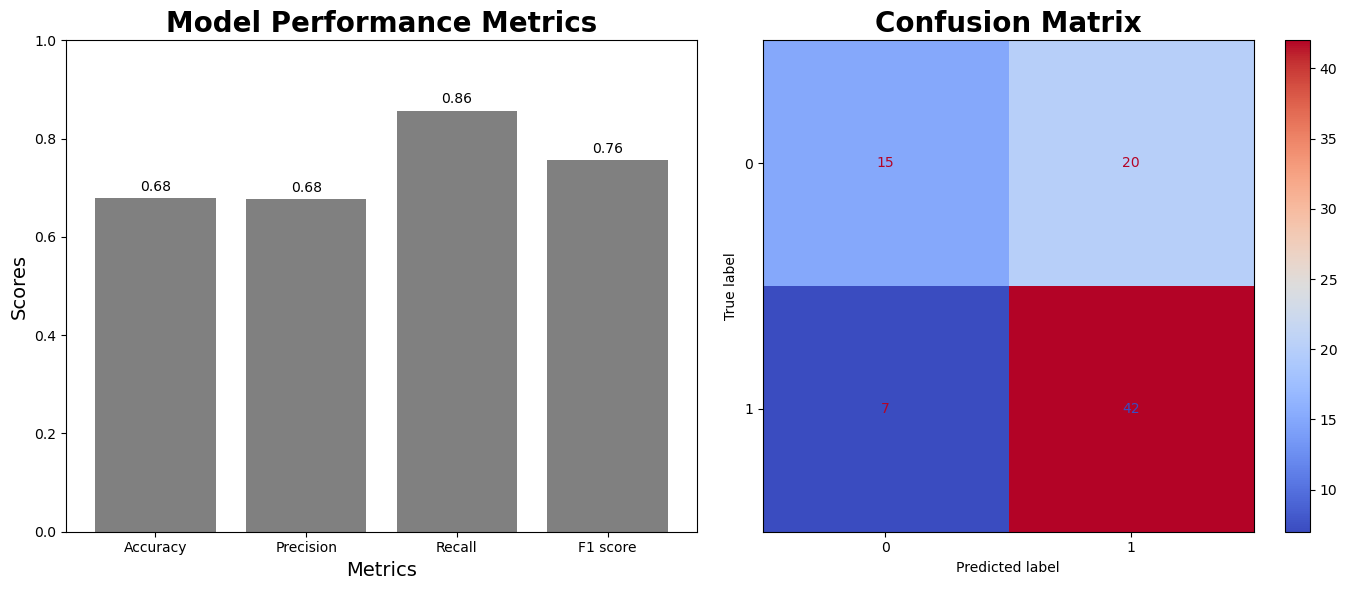

In [161]:
df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0), 1, 0)
df21['actual binary'] = np.where(df21['real return']>0, 1, 0)
plot_model_performance(df21['predicted binary'], df21['actual binary'])

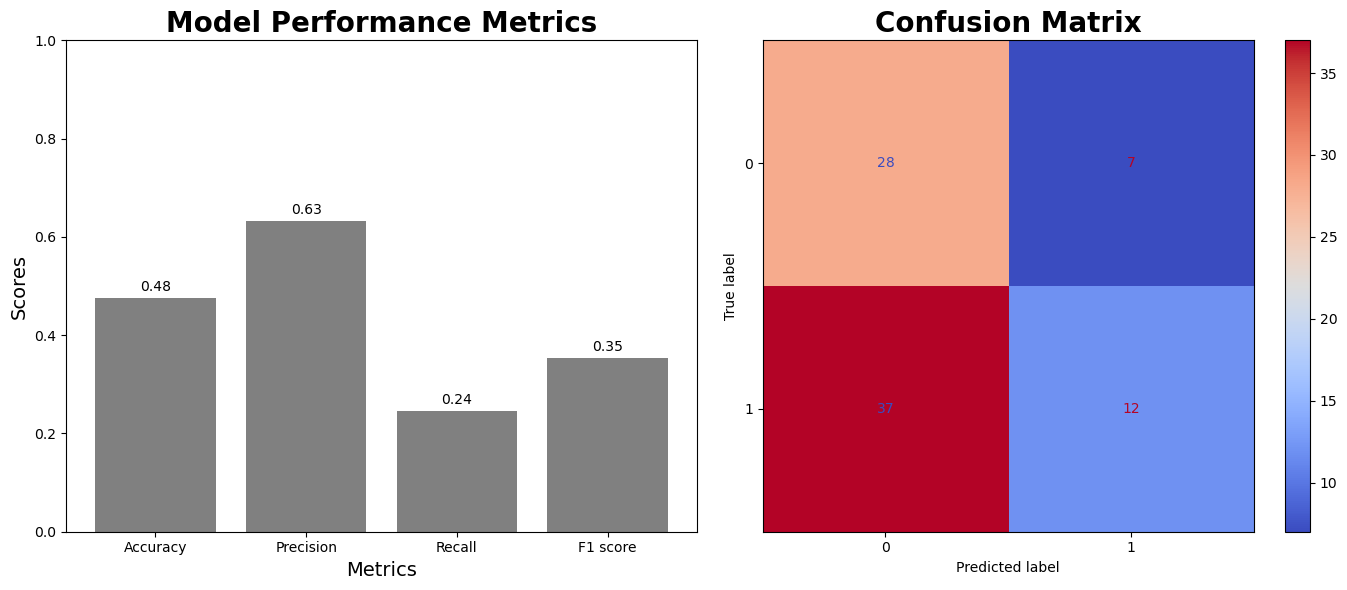

In [162]:
df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0) & (df21['predicted return difference compared with today_corrected']>df21['threshold']), 1, 0)
# df21['predicted binary'] = np.where((df21['predicted return difference compared with today_corrected'] >0), 1, 0)
df21['actual binary'] = np.where(df21['real return']>0, 1, 0)
plot_model_performance(df21['predicted binary'], df21['actual binary'])

# Summary

As we can see in this note book, we have predicted the 1-day, 5-day, and 1-month return based on ARIMA and evaluate the different models with psedu-classification metrics. 

There are two types of the ARIMA models: one is using all the existing data until the current date to train the model while the other one is using the sliding window to define where the model will be trained on. 

There are also two different crietria to define the positive trend('1') and ('0'). The softer one is using 0 as the threshold while the more restrict one is using the 1 std + past 5 days' moverage as the threshold. It turns out that there are many combination of the parameters in the model. The choose of different parameters will result in different performance in different validation targets. We present a table below for a better understanding. 


|         | model-ARIMA             | parameters(p,d,q) | criteria | accuracy | precision | recall | f1 score |
|---------|-------------------------|-------------------|----------|----------|-----------|--------|----------|
| 1-day   | all-exist data          | (1,0,0)           | soft(0)  | 0.52     | 0.54      | 0.93   | 0.66     |
| 1-day   | all-exist data          | (1,0,0)           | restrict | 0.45     | 0.5       | 0.07   | 0.12     |
| 1-day   | moving window(50 days)  | (1,0,0)           | soft(0)  | 0.59     | 0.63      | 0.58   | 0.61     |
| 1-day   | moving window(50 days)  | (1,0,0)           | restrict | 0.45     | 0         | 0      | 0        |
| 5-day   | all-exist data          | (7,0,0)           | soft(0)  | 0.58     | 0.58      | 0.87   | 0.70     |
| 5-day   | all-exist data          | (7,0,0)           | restrict | 0.5      | 0.58      | 0.33   | 0.42     |
| 5-day   | moving window(300 days) | (7,0,0)           | soft(0)  | 0.52     | 0.55      | 0.65   | 0.60     |
| 5-day   | moving window(300 days) | (7,0,0)           | restrict | 0.53     | 0.72      | 0.24   | 0.36     |
| 1-month | all-exist data          | (1,0,0)           | soft(0)  | 0.58     | 0.59      | 0.94   | 0.72     |
| 1-month | all-exist data          | (1,0,0)           | restrict | 0.40     | 0.49      | 0.39   | 0.43     |
| 1-month | moving window(300 days) | (1,0,0)           | soft(0)  | 0.68     | 0.68      | 0.86   | 0.76     |
| 1-month | moving window(300 days) | (1,0,0)           | restrict | 0.48     | 0.63      | 0.24   | 0.35     |